# TOC entitlements near bus/rail lines
* Which bus/rail lines or rail stations have seen the most TOC entitlement activity?
* Which ones have seen lots of non-TOC entitlement activity? 

In [1]:
import functools
import contextily
import intake
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import utils
import boto3

In [ ]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 20)

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## Assign entitlements to conditions

In [3]:
toc_tiers = utils.reconstruct_toc_tiers_file()

parcels = gpd.read_file(
    f"s3://{bucket_name}/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
).to_crs({'init':'epsg:4326'})

In [4]:
toc_parcels = parcels[parcels.num_TOC > 0]

In [5]:
df = utils.parcels_join_toc_tiers(toc_parcels, toc_tiers)

## Which rule?

In [8]:
tier_1 = df[df.TOC_Tier == 1]
tier_2 = df[df.TOC_Tier == 2]
tier_3 = df[df.TOC_Tier == 3]
tier_4 = df[df.TOC_Tier == 4]

Text(0.6, -1.0, 'TOC Entitlements')

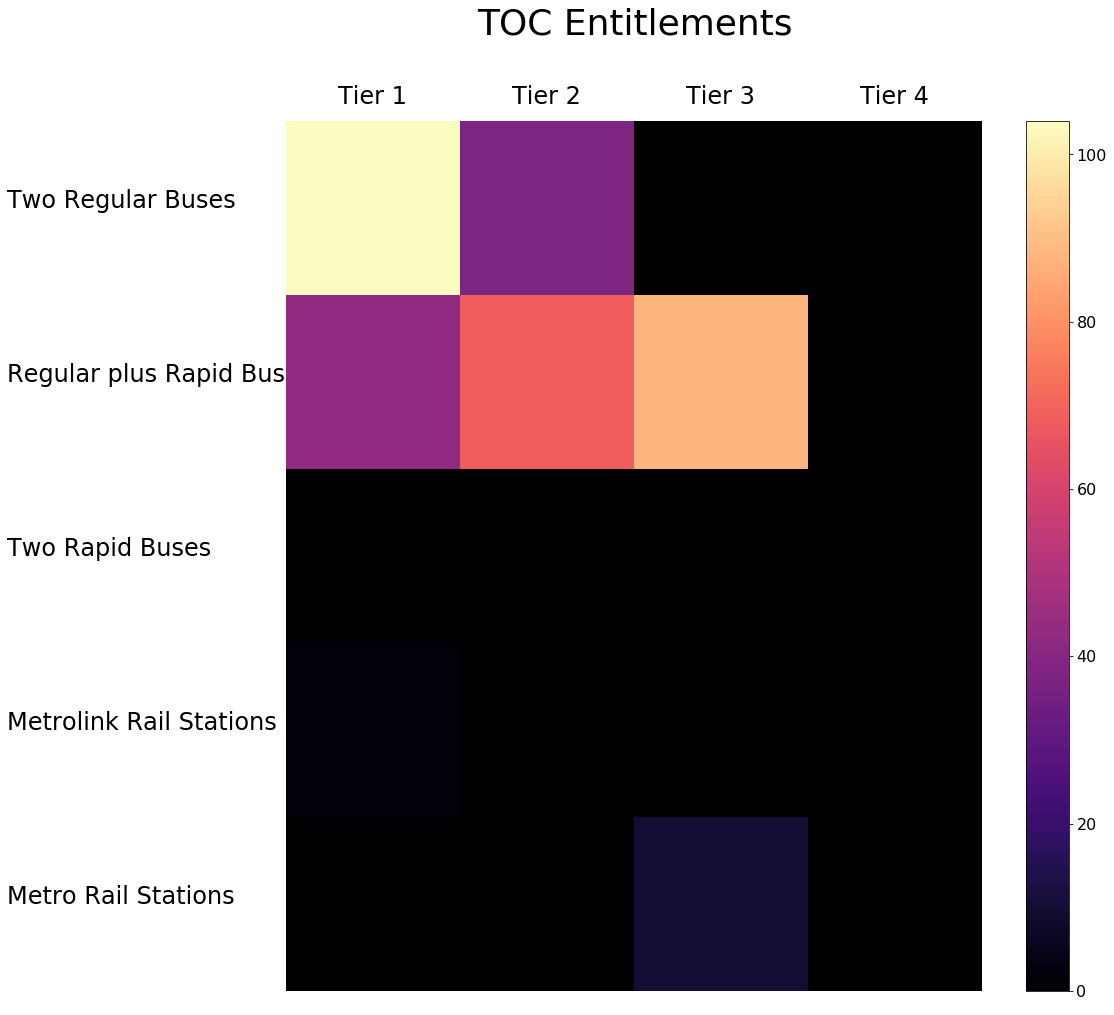

In [14]:
table = np.zeros(shape=(5, 4))
table[4,3] = tier_4[(tier_4.mode_a=="metro") & (tier_4.mode_b.isin(["metro", "bus"]))].num_TOC.sum()
table[4,2] = tier_4[tier_4.mode_a=="metro"].num_TOC.sum()
table[3,2] = tier_3[tier_3.mode_a=="metrolink"].num_TOC.sum()
table[3,1] = tier_2[tier_2.mode_a=="metrolink"].num_TOC.sum()
table[3,0] = tier_1[tier_1.mode_a=="metrolink"].num_TOC.sum()
table[2,2] = tier_3[tier_3.a_rapid & tier_3.b_rapid].num_TOC.sum()
table[2,1] = tier_2[tier_2.a_rapid & tier_2.b_rapid].num_TOC.sum()
table[1,2] = tier_3[tier_3.a_rapid ^ tier_3.b_rapid].num_TOC.sum()
table[1,1] = tier_2[tier_2.a_rapid ^ tier_2.b_rapid].num_TOC.sum()
table[1,0] = tier_1[tier_1.a_rapid ^ tier_1.b_rapid].num_TOC.sum()
table[0,1] = tier_2[~tier_2.a_rapid & ~tier_2.b_rapid].num_TOC.sum()
table[0,0] = tier_1[~tier_1.a_rapid & ~tier_1.b_rapid].num_TOC.sum()


fig, ax = plt.subplots(figsize=(16,16))
pos = ax.imshow(table, cmap="magma")
ax.set_axis_off()
ax.text(-2.1, 0.0, "Two Regular Buses", fontsize=24)
ax.text(-2.1, 1.0, "Regular plus Rapid Bus", fontsize=24)
ax.text(-2.1, 2.0, "Two Rapid Buses", fontsize=24)
ax.text(-2.1, 3.0, "Metrolink Rail Stations", fontsize=24)
ax.text(-2.1, 4.0, "Metro Rail Stations", fontsize=24)
ax.text(-0.2, -0.6, "Tier 1", fontsize=24)
ax.text(0.8, -0.6, "Tier 2", fontsize=24)
ax.text(1.8, -0.6, "Tier 3", fontsize=24)
ax.text(2.8, -0.6, "Tier 4", fontsize=24)
cb = fig.colorbar(pos, ax=ax)
cb.ax.tick_params(labelsize=16)
ax.text(0.6, -1.0, "TOC Entitlements", fontsize=36)
#plt.savefig("toc.png", bbox_inches='tight')

## By Tier and Line

In [29]:
def summarize(tier, header):
    display(Markdown(header))
    metro_rail_summary = (
        tier[tier.mode_a=="metro"].groupby(["station_name"])
        .agg({"num_TOC":"sum", "num_nonTOC":"sum"})
        .sort_values(['num_TOC', 'num_nonTOC'], ascending = [False, False])
    )
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
    
    metrolink_summary = (
        tier[tier.mode_a=="metrolink"].groupby("station_name")
        .agg({"num_TOC":"sum", "num_nonTOC":"sum"})
        .sort_values(['num_TOC', 'num_nonTOC'], ascending = [False, False])

    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("station_name")
    )
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
    
    a = tier[tier.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    b = tier[tier.mode_b=="bus"].groupby("line_name_b").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values(["num_TOC", "num_nonTOC"], ascending=[False, False]).head(60))

In [30]:
# TODO: Figure out a better deduplicating strategy.
summarize(tier_1.drop_duplicates(subset=["AIN"]), "## Tier 1 Statistics")
summarize(tier_2.drop_duplicates(subset=["AIN"]), "## Tier 2 Statistics")
summarize(tier_3.drop_duplicates(subset=["AIN"]), "## Tier 3 Statistics")
summarize(tier_4.drop_duplicates(subset=["AIN"]), "## Tier 4 Statistics")

## Tier 1 Statistics

#### Bus Lines

,num_TOC,num_nonTOC
Bus Route,,
207,5,0
757,5,0
14/37,4,0
224,4,0
233,4,0
603,4,0
212/312,3,2
704,3,2
152/353,3,0


## Tier 2 Statistics

#### Bus Lines

,num_TOC,num_nonTOC
Bus Route,,
728,11,0
33,10,0
206,9,0
R12,9,0
204,8,0
754,8,0
704,5,0
757,4,0
200,3,0


## Tier 3 Statistics

#### Metro Rail

,num_TOC,num_nonTOC
station_name,,
Westlake / MacArthur Park Station,10,0
Century City/Constellation,9,0
Wilshire / Normandie Station,9,0
Wilshire / Vermont Station,8,2
North Hollywood Station,7,0
Florence/Hindry,5,0
Vermont / Sunset Station,4,0
Expo / Bundy Station,3,0
Pico / Aliso Station,3,0


#### Bus Lines

,num_TOC,num_nonTOC
Bus Route,,
757,14,6
207,9,1
217,9,0
780,9,0
33,6,5
754,6,0
105,4,0
204,4,0
1,3,0


## Tier 4 Statistics

#### Metro Rail

,num_TOC,num_nonTOC
station_name,,
Vermont / Santa Monica Station,3,3
Vermont / Sunset Station,3,0
Wilshire / Western Station,2,1
Wilshire / Normandie Station,1,1
Hollywood / Highland Station,1,0


## By Line

In [31]:
metro_df = df[(df.mode_a == 'metro') | (df.mode_b == 'metro')]

In [35]:
metro_df.columns

Index(['AIN', 'TOC_Tier', 'zone_class', 'num_TOC', 'num_nonTOC', 'geometry',
       'tiers_id', 'line_id_a', 'line_id_b', 'line_name_a', 'line_name_b',
       'station_id', 'station_name', 'tier_1', 'tier_2', 'tier_3', 'tier_4',
       'mode_a', 'mode_b', 'agency_a', 'agency_b', 'a_rapid', 'b_rapid',
       'within_tier'],
      dtype='object')

In [41]:
metro_df.head()

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


,AIN,TOC_Tier,zone_class,num_TOC,num_nonTOC,geometry,tiers_id,line_id_a,line_id_b,line_name_a,...,tier_2,tier_3,tier_4,mode_a,mode_b,agency_a,agency_b,a_rapid,b_rapid,within_tier
232,2338024019,3,C2,1,0,POINT (-118.37934 34.17539),863.0,,,,...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"POLYGON ((-118.37383 34.16851, -118.37385 34.1...",metro,,Metro - Los Angeles,,False,False,3
233,2338024040,3,C2,1,0,POINT (-118.37934 34.17553),863.0,,,,...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"POLYGON ((-118.37383 34.16851, -118.37385 34.1...",metro,,Metro - Los Angeles,,False,False,3
234,2350004031,3,C4,1,0,POINT (-118.37960 34.17175),863.0,,,,...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"POLYGON ((-118.37383 34.16851, -118.37385 34.1...",metro,,Metro - Los Angeles,,False,False,3
235,2350004032,3,R4,1,0,POINT (-118.37972 34.17153),863.0,,,,...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"POLYGON ((-118.37383 34.16851, -118.37385 34.1...",metro,,Metro - Los Angeles,,False,False,3
236,2350010013,3,R3,1,0,POINT (-118.38289 34.16938),863.0,,,,...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"POLYGON ((-118.37383 34.16851, -118.37385 34.1...",metro,,Metro - Los Angeles,,False,False,3


In [21]:
def summarize(df, transit, header):
    display(Markdown(header))
    
    if transit == 'bus':
        bus_df = df[(df.mode_a == 'bus') | (df.mode_b == 'bus')]

        a = bus_df[bus_df.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum"})
        b = bus_df[bus_df.mode_b=="bus"].groupby("line_name_b").agg({"num_TOC":"sum"})
        bus_summary = (
            a.reindex(
                index=(a.index | b.index).rename("Bus Route")
            ).fillna(0).astype("int") + 
            b.reindex(
                index=(a.index | b.index).rename("Bus Route")
            ).fillna(0).astype("int")
        )
        
        if len(bus_summary):
            display(Markdown("#### Bus Lines"))
            display(bus_summary.sort_values(["num_TOC", "num_nonTOC"], ascending=[False, False]).head(60))
        
    if transit == 'metro':
        metro_df = df[(df.mode_a == 'metro') | (df.mode_b == 'metro')]
    
        metro_rail_summary = (
            metro_df[metro_df.mode_a=="metro"].groupby(["station_name"])
            .agg({"num_TOC":"sum"})
            .sort_values(['num_TO'], ascending = [False])
        )
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
    
    metrolink_summary = (
        tier[tier.mode_a=="metrolink"].groupby("station_name")
        .agg({"num_TOC":"sum", "num_nonTOC":"sum"})
        .sort_values(['num_TOC', 'num_nonTOC'], ascending = [False, False])

    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("station_name")
    )
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
    
    a = tier[tier.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    b = tier[tier.mode_b=="bus"].groupby("line_name_b").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values(["num_TOC", "num_nonTOC"], ascending=[False, False]).head(60))

Index(['AIN', 'TOC_Tier', 'zone_class', 'num_TOC', 'num_nonTOC', 'geometry',
       'tiers_id', 'line_id_a', 'line_id_b', 'line_name_a', 'line_name_b',
       'station_id', 'station_name', 'tier_1', 'tier_2', 'tier_3', 'tier_4',
       'mode_a', 'mode_b', 'agency_a', 'agency_b', 'a_rapid', 'b_rapid',
       'within_tier'],
      dtype='object')

In [24]:
bus.head(2)

,AIN,TOC_Tier,zone_class,num_TOC,num_nonTOC,geometry,tiers_id,line_id_a,line_id_b,line_name_a,...,tier_2,tier_3,tier_4,mode_a,mode_b,agency_a,agency_b,a_rapid,b_rapid,within_tier
0,2212003014,1,C2,1,0,POINT (-118.44824 34.21900),269.0,233-13108,152-13108,233,...,"POLYGON ((-118.44577 34.22156, -118.44579 34.2...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,bus,bus,Metro - Los Angeles,Metro - Los Angeles,False,False,1
2,2212003017,1,C2,1,0,POINT (-118.44824 34.21927),269.0,233-13108,152-13108,233,...,"POLYGON ((-118.44577 34.22156, -118.44579 34.2...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,bus,bus,Metro - Los Angeles,Metro - Los Angeles,False,False,1


In [28]:
# Since the entitlement to attributed to multiple lines,
# we will naturally be counting bus lines multiple times

a = bus.groupby(['line_name_a']).agg({'num_TOC':'sum'}).sort_values(
    'num_TOC', ascending = False).reset_index().
b = bus.groupby(['line_name_b']).agg({'num_TOC':'sum'}).sort_values(
    'num_TOC', ascending = False).reset_index()

    a = tier[tier.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    b = tier[tier.mode_b=="bus"].groupby("line_name_b").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")



/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,line_name_a,line_name_b,num_TOC
0,757,NaN,45
1,754,NaN,29
2,704,NaN,17
3,14/37,NaN,17
4,728,NaN,16
...,...,...,...
35,NaN,750,1
36,NaN,111,1
37,NaN,14/37,1
38,NaN,78/79/378,1
